# Two-Copy Witness Search for GME Activation

This notebook implements a semidefinite programming (SDP) approach to search for a two-copy entanglement witness operator for a noisy biseparable state, relevant to genuine multipartite entanglement (GME) activation. It constructs the target state, sets up the SDP constraints using partial transposes, solves for the optimal witness operator, and analyzes its decomposition in the Pauli basis. The results include visualization of the witness structure, extraction of significant measurement terms, and saving of relevant data for further use.

Results are saved in H5 format in file `two-copy-witness.h5`.

In [1]:
from time import time
import itertools
import numpy as np
import matplotlib.pyplot as plt
import picos
from tqdm.notebook import trange, tqdm
import h5py

from auxpauli import spawn_generalized_pauli_operators
import KetSugar as ks


In [ ]:
def swap_ij(n : int, i : int, j : int ) -> np.ndarray:
    """
    Generate swap operator for n-qubit system. Qubits i and j are swapped.    
    """
    left_qubits = i
    central_qubits = (j - i) - 1
    right_qubits = (n - j) - 1
    eye_left = np.eye(1 << left_qubits)
    eye_center = np.eye(1 << central_qubits)
    eye_right = np.eye(1 << right_qubits)    
    ket_01 = ks.kron(eye_left, ks.LO, eye_center, ks.HI, eye_right)
    ket_10 = ks.kron(eye_left, ks.HI, eye_center, ks.LO, eye_right)
    bra_01 = ks.dagger(ket_01)
    bra_10 = ks.dagger(ket_10)
    swap = np.eye(1 << n, dtype=complex) \
        - ket_01 @ bra_01 - ket_10 @ bra_10 \
        + ket_01 @ bra_10 + ket_10 @ bra_01
    return swap

#three-qubit swaps
swaps = {(i,j) : swap_ij(6, i, j) for i,j in itertools.combinations([0,1,2,3,4,5], 2)}

# decomposition of noisy isotropic GHZ state into three biseparable states

rhoR1 = np.zeros((8,8), dtype=complex)
np.fill_diagonal(rhoR1, [1,0,0,1]*2)
rhoR1[-1,0] = 1
rhoR1[0,-1] = 1
rhoR1 /= 4

rhoR2 = np.zeros((8,8), dtype=complex)
np.fill_diagonal(rhoR2, [1]*2+[0]*4 + [1]*2)
rhoR2[-1,0] = 1
rhoR2[0,-1] = 1
rhoR2 /= 4

rhoR3 = np.zeros((8,8), dtype=complex)
np.fill_diagonal(rhoR3, [1,0,1]+[0]*2 + [1,0,1]*2)
rhoR3[-1,0] = 1
rhoR3[0,-1] = 1
rhoR3 /= 4

# the simplified biseparable activatable state
rhoR23 = (rhoR2 + rhoR3)/2

# two copies of that state
rho_2_copies = np.kron(rhoR23, rhoR23)

#swapping operator from order ABCABC to AABBCC
u_swap = swaps[(3,4)] @ swaps[(1,2)] @ swaps[(2,3)]
rho = ks.ApplyOp(rho_2_copies, u_swap)

# get density matrices of a single and two copies of the activatable state with extra colored noise
colored_noise = np.diag([0,0,0,1,1,0,0,0])/2
q = 0.06
rhoR23n = rhoR23.real*(1-q) + (q)*colored_noise
rho_2_copies_n = np.kron(rhoR23n, rhoR23n)
rho_n = ks.ApplyOp(rho_2_copies_n, u_swap)

In [3]:
# Define SDP program for searching the witness

P = picos.Problem()
REF = picos.Constant(rho)
W = picos.HermitianVariable('W', (64,64))
P.add_constraint(picos.trace(W) == 1)
biparts = [
    [0,1],
    [2,3],
    [4,5]
]
for k in [0,1,2]:
    Pk = picos.HermitianVariable(f'P_{k}', shape = (64, 64))
    Qk = picos.partial_transpose(W - Pk, biparts[k], [2,2,2,2,2,2])
    P.add_constraint(Qk >> 0)
    P.add_constraint(Pk >> 0)

# Construct the objective
F = picos.trace(W * REF).real
P.set_objective('min', F)

In [4]:
# Run the solver, this might be time-consuming
t0 = time()
S = P.solve(solver='mosek')
t1 = time()
print(S)
print(t1 - t0)

primal feasible solution pair (claimed optimal) from mosek
276.34408736228943


In [5]:
# Print the found witness value and operator
print(F.value)
print(float(F))
W_op_R23 = np.array(W)
print(W_op_R23.shape)

-0.010416666666639528
-0.010416666666639528
(64, 64)


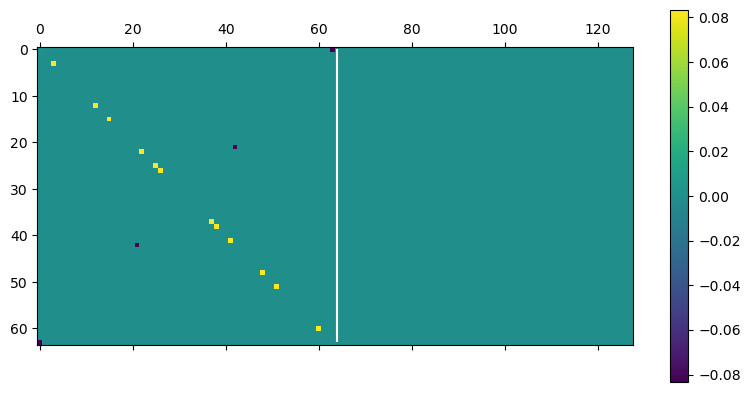

In [6]:
# Show witness structure
plt.matshow(np.hstack([W.real, W.imag]))
plt.vlines([64],0,63, colors='w')
plt.colorbar()
plt.show()

In [7]:
# Generate Pauli strings for 6 qubits starting from II...I, II...Z, ..., YY...Y.
paulis = spawn_generalized_pauli_operators(*([np.eye(2)]*6))

# Decompose witness operator into Pauli basis
weights = np.array([(p.T.ravel() @ W.np.ravel()).real for p in tqdm(paulis)]) #tr Rho W
indices = np.arange(4096)

  0%|          | 0/4096 [00:00<?, ?it/s]

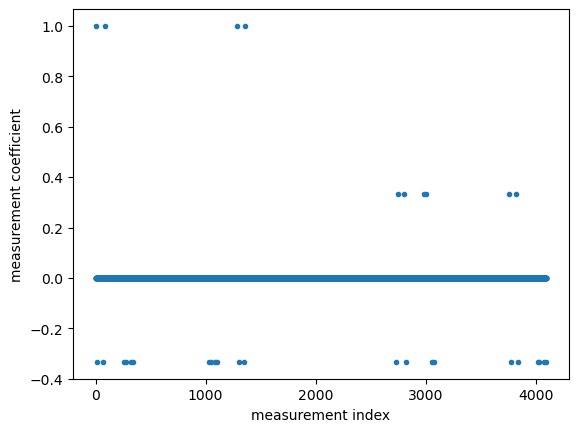

number of nonzeros: 32


In [8]:
plt.plot(indices, weights, ".")
plt.xlabel("measurement index")
plt.ylabel("measurement coefficient")
plt.show()
n_nonzero = sum(np.abs(weights) > 1e-3)
print(f'number of nonzeros: {n_nonzero}') #

In [25]:
threshold = 1e-2
non_negligable = np.abs(weights)>threshold
print(weights[non_negligable])

important_weights = weights[non_negligable]
table_mstrings = [''.join(mcode)[::-1] for (w, mcode) in zip(weights, itertools.product('IZXY', repeat=6)) if abs(w) > threshold]
table_to_be_meased = ['Z'*6] + table_mstrings[16:]

[ 1.         -0.33333333 -0.33333333  1.         -0.33333333 -0.33333333
 -0.33333333 -0.33333333 -0.33333333 -0.33333333 -0.33333333 -0.33333333
  1.         -0.33333333 -0.33333333  1.         -0.33333333  0.33333333
  0.33333333 -0.33333333  0.33333333  0.33333333 -0.33333333 -0.33333333
  0.33333333 -0.33333333  0.33333333 -0.33333333 -0.33333333 -0.33333333
 -0.33333333 -0.33333333]


In [32]:
# Generate witness measurement table and save it

with h5py.File('two-copy-witness.h5', 'w') as h5f:
    dset_wit = h5f.create_dataset('two_copy_operator', data = W.np)
    dset_tab_factors = h5f.create_dataset('two_copy_table_factors', data = weights[non_negligable])
    dset_tab_meas_full = h5f.create_dataset('two_copy_table_meas_full', data = table_mstrings)
    dset_tab_meas = h5f.create_dataset('two_copy_table_meas', data = table_to_be_meased)
    dset_target_state = h5f.create_dataset('witness_target_state', data = rho)


### Check some properties of the found witness operator

In [33]:
# Decompose witness into P and Q operators
import departed
Wm = np.array(W.np)
PQ = {
    'P_0' : np.array(P.get_variable('P_0').np),
    'P_1' : np.array(P.get_variable('P_1').np),
    'P_2' : np.array(P.get_variable('P_2').np),
    'Q_0' : departed.ptranspose(Wm - P.get_variable('P_0').np, [2]*6, [1,1,0,0,0,0]),
    'Q_1' : departed.ptranspose(Wm - P.get_variable('P_1').np, [2]*6, [0,0,1,1,0,0]),
    'Q_2' : departed.ptranspose(Wm - P.get_variable('P_2').np, [2]*6, [0,0,0,0,1,1])
}

In [34]:
# check positive semidefiniteness>
for key, m in PQ.items():
    print(key, np.min(np.linalg.eigvalsh(m)))

P_0 -3.921759900865623e-15
P_1 -8.462362657869224e-16
P_2 -1.1066947251178053e-15
Q_0 -8.927224600807168e-16
Q_1 -2.049685593686305e-15
Q_2 -2.2523327135972633e-15


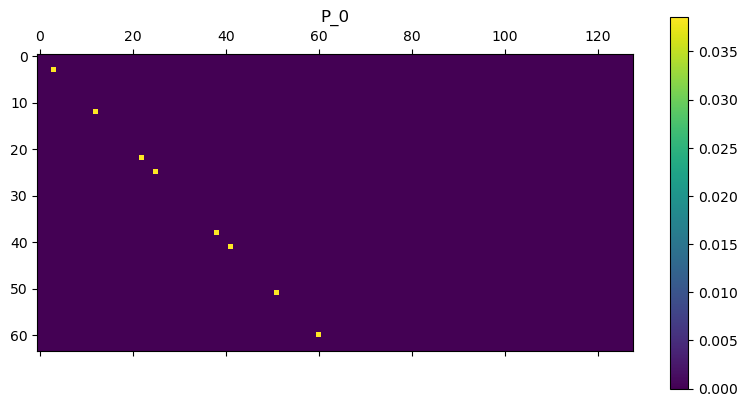

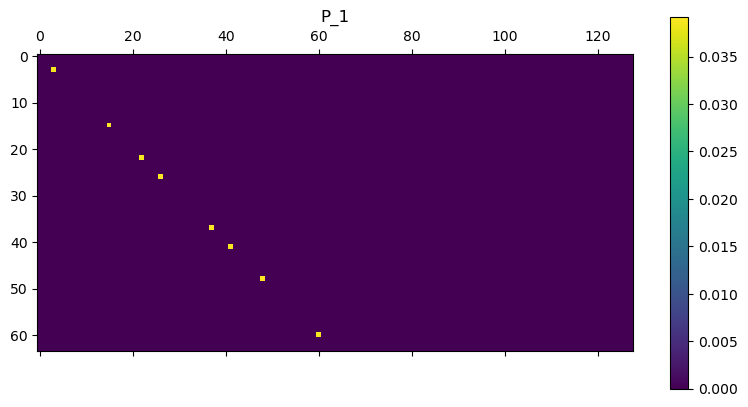

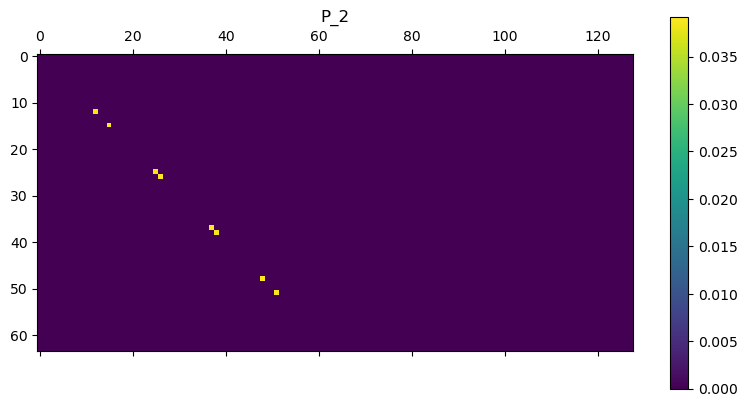

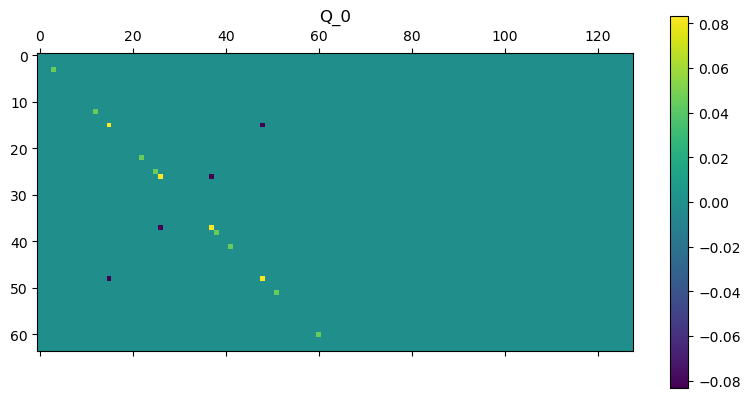

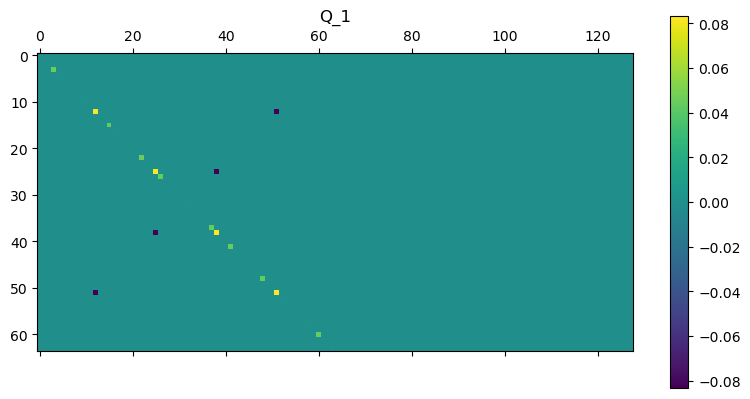

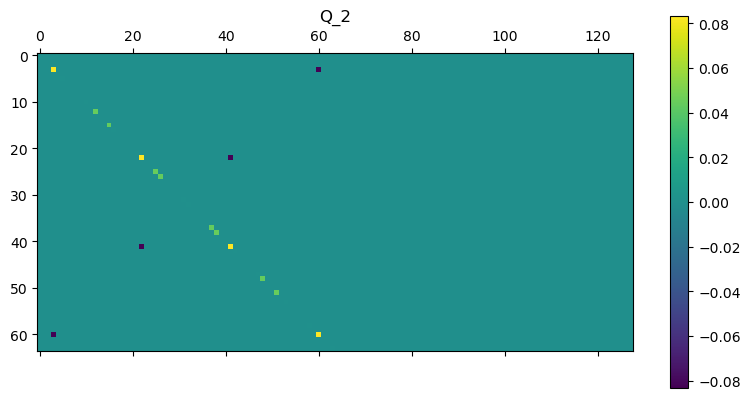

In [35]:
#Show the structure of decomposition terms
for key, m in PQ.items():
    plt.matshow(np.hstack((m.real, m.imag)))
    plt.title(key)
    plt.colorbar()

In [36]:
# Print analytical form
for key, m in PQ.items():
    print(f"=== {key} ===")
    val_list = []
    for row in range(64):
        for col in range(64):
            el = m[row, col]            
            if np.abs(el)>1e-6:
                print(f'{row}\t{col}\t|{row:06b}><{col:06b}|\t{el.real:03e}\t')
                val_list.append(np.round(el.real,5))
    print(set(val_list))
m = Wm
print(f"=== WIT ===")
val_list = []
for row in range(64):
    for col in range(64):
        el = m[row, col]
        if np.abs(el)>1e-6:
            print(f'{row}\t{col}\t|{row:06b}><{col:06b}|\t{el.real:03e}\t')
            val_list.append(np.round(el.real,5))
print(set(val_list))            

=== P_0 ===
3	3	|000011><000011|	3.863026e-02	
12	12	|001100><001100|	3.863026e-02	
22	22	|010110><010110|	3.863026e-02	
25	25	|011001><011001|	3.863026e-02	
38	38	|100110><100110|	3.863026e-02	
41	41	|101001><101001|	3.863026e-02	
51	51	|110011><110011|	3.863026e-02	
60	60	|111100><111100|	3.863026e-02	
{0.03863}
=== P_1 ===
3	3	|000011><000011|	3.863026e-02	
15	15	|001111><001111|	3.923156e-02	
22	22	|010110><010110|	3.863026e-02	
26	26	|011010><011010|	3.923156e-02	
37	37	|100101><100101|	3.923156e-02	
41	41	|101001><101001|	3.863026e-02	
48	48	|110000><110000|	3.923156e-02	
60	60	|111100><111100|	3.863026e-02	
{0.03863, 0.03923}
=== P_2 ===
12	12	|001100><001100|	3.863026e-02	
15	15	|001111><001111|	3.923156e-02	
25	25	|011001><011001|	3.863026e-02	
26	26	|011010><011010|	3.923156e-02	
37	37	|100101><100101|	3.923156e-02	
38	38	|100110><100110|	3.863026e-02	
48	48	|110000><110000|	3.923156e-02	
51	51	|110011><110011|	3.863026e-02	
{0.03863, 0.03923}
=== Q_0 ===
3	3	|000011><000011|